# UMAP Analysis and Plotting

This notebook goes through the basic steps of creating a UMAP embedding.  It uses the interactive plotting environment
*plotly* to create dynamic visualizations of different variables with the option to save them to .png files.

In [1]:
# import statements
import json
import pandas as pd
import yaml
from utils import umap_utils as uu
import copy
import os
from tqdm import tqdm, trange
import numpy as np
import os
import plotly.graph_objects as go
import plotly.express as px
from jupyter_dash import JupyterDash
from dash import Dash, dcc, html, Input, Output, no_update

## Specify the configuration file

The configuration file should be a `.yml` format like this:

```
UMAP_SETTINGS:
  LD_COLUMNS: ['z0', 'z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'z7',
  'z8', 'z9', 'z10', 'z11', 'z12', 'z13', 'z14', 'z15',
  'z16', 'z17', 'z18', 'z19', 'z20', 'z21', 'z22', 'z23',
  'z24', 'z25', 'z26', 'z27', 'z28', 'z29', 'z30', 'z31']
  NUM_COMPONENTS: 32
  NUM_NEIGHBORS: [5]
  MIN_DISTANCE: [0.001]
  
DATA:
  FILE_PATH: '/home/daleas/umap/data/20210608T1001dataFrame.csv'
  IMAGE_PATH: '/home/daleas/VAE_RGBZ/'
  CLASSES: ["Plane", "Glider", "Kite", "Quadcopter", "Eagle"]
  SUPERCLASSES: ["RW", "VW"]
  CLASS_MAP: {"Plane": 0, "Glider": 1, "Kite": 2, "Quadcopter":3, "Eagle":4}
  SUPERCLASS_MAP: {"RW": 0, "VW": 1}
  CLASS_DICT: { "RW": {"Plane": {'x': [], 'y': [], 'z': []},
                               "Glider": {'x': [], 'y': [], 'z': []},
                               "Kite": {'x': [], 'y': [], 'z': []},
                               "Quadcopter": {'x': [], 'y': [], 'z': []},
                               "Eagle": {'x': [], 'y': [], 'z': []}},
                        "VW": {"Plane": {'x': [], 'y': [], 'z': []},
                              "Glider":{'x': [], 'y': [], 'z': []},
                              "Kite": {'x': [], 'y': [], 'z': []},
                              "Quadcopter": {'x': [], 'y': [], 'z': []},
                              "Eagle": {'x': [], 'y': [], 'z': []}}
                       }`
  SUPERCLASS_DICT: {"RW": {'x':[], 'y':[], 'z':[]}, "VW": {'x':[], 'y':[], 'z':[]}}
```

You can specify whatever classes, superclasses, and class mappings you like.  There is a way to auto-generate some of this, but I haven't had time to write it up.

Specifying the configuration file automatically loads variables and data, and allows for testing different UMAP combinations

In [4]:
cwd = os.getcwd()

In [6]:
### CHANGE THIS PATH: 
config_file = os.path.join(cwd, 'config/RGBdata_32D.yml')

## Load Data and Settings

The following two cells should not require adjusting

In [9]:
with open(config_file) as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

FILE_PATH = os.path.join(cwd, config['DATA']['FILE_PATH'])
LD_COLUMNS = config['UMAP_SETTINGS']['LD_COLUMNS']
MIN_DISTANCE = config['UMAP_SETTINGS']['MIN_DISTANCE']
NUM_NEIGHBORS = config['UMAP_SETTINGS']['NUM_NEIGHBORS']
NUM_COMPONENTS = config['UMAP_SETTINGS']['NUM_COMPONENTS']
CLASS_MAP = config['DATA']['CLASS_MAP']
SUPERCLASS_MAP = config['DATA']['SUPERCLASS_MAP']
CLASS_DICT = config['DATA']['CLASS_DICT']
SUPERCLASS_DICT = config['DATA']['SUPERCLASS_DICT']
CLASSES = config['DATA']['CLASSES']
SUPERCLASSES = config['DATA']['SUPERCLASSES']
IMAGE_PATH = config['DATA']['IMAGE_PATH']

port_num = 8050

In [10]:
[saveDirPath, file] = os.path.split(FILE_PATH)

saveDir = os.path.join(saveDirPath, 'umap')
if not os.path.exists(saveDir):
    os.mkdir(saveDir)
os.chdir(saveDir)

latentData = pd.read_csv(FILE_PATH)
latentData_z = latentData[LD_COLUMNS].values
imgList = latentData.filename.values
imgLabels1 = latentData.DataType.values
df_imgLabels1 = pd.DataFrame(imgLabels1, columns=['DataType'])
imgLabels2 = latentData.Class.values
df_imgLabels2 = pd.DataFrame(imgLabels2, columns=['Class'])
df_imgList = pd.DataFrame(imgList, columns=['Name'])
labels_true_class = [SUPERCLASS_MAP[class_str] for class_str in imgLabels1]
df_labels_true_class = pd.DataFrame(labels_true_class, columns=['GT_ID'])

# Sort the Data Into Classes
classLabels = copy.deepcopy(CLASSES)
dataTypesLabels = copy.deepcopy(SUPERCLASSES)
labeledDataByClass = copy.deepcopy(CLASS_DICT)
labeledDataByType = copy.deepcopy(SUPERCLASS_DICT)

label1 = [classLabels[x] for x in latentData.Class.map(CLASS_MAP)]
label2 = [dataTypesLabels[x] for x in latentData.DataType.map(SUPERCLASS_MAP)]

### Preview the loaded data here
The first five rows of data should automatically load, so that you can see that everything is correct

In [11]:
latentData.head()

,Unnamed: 0,filename,z_filename,img_path,z_img_path,Class,DataType,z0,z1,z2,...,z22,z23,z24,z25,z26,z27,z28,z29,z30,z31
0,0,biplane_00.png,None,data/biplane_00.png,data/None,Plane,RW,-29.119888,203.92926,-59.197700,...,195.43346,-158.05522,59.936710,118.28850,166.49731,163.83456,-97.614210,101.91274,179.30849,-21.362705
1,1,biplane_01.png,None,data/biplane_01.png,data/None,Plane,RW,-69.793520,224.46770,-126.900120,...,230.45184,-158.64777,9.611135,96.74483,193.25102,131.40953,-89.429040,136.76639,205.77017,-53.355366
2,2,biplane_03.png,None,data/biplane_03.png,data/None,Plane,RW,-64.213350,247.62384,-118.700080,...,245.82910,-178.26122,41.728706,128.31956,201.45428,160.12694,-113.652695,146.62924,222.21864,-53.345856
3,3,biplane_04.png,None,data/biplane_04.png,data/None,Plane,RW,-70.398420,201.52945,-118.945120,...,201.06625,-146.41835,-1.645173,76.77112,180.55313,108.82903,-79.443950,123.19585,187.33340,-46.025455
4,4,biplane_05.png,None,data/biplane_05.png,data/None,Plane,RW,-62.893900,242.21210,-106.510605,...,248.32800,-180.29260,47.390556,144.39601,208.17581,168.18546,-108.139900,137.94940,227.46078,-42.878925


## Plot Latent Space Before UMAP

A visual check as to how entangled the original feature space is

/Users/ashley/Downloads/umap-main/utils/umap_utils.py:142: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(np.array(labeledDataByClass['RW'][class_name]['x']),


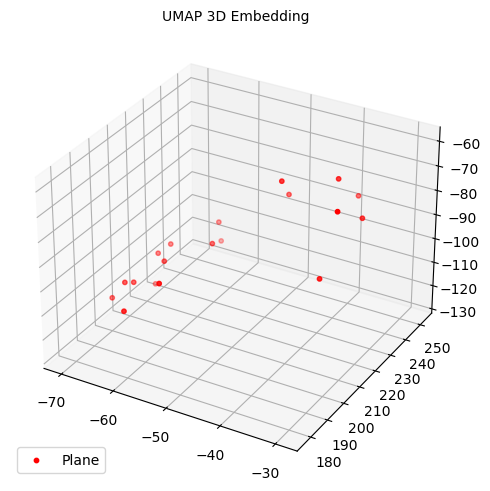

/Users/ashley/Downloads/umap-main/utils/umap_utils.py:168: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(np.array(labeledDataByType['VW']['x']),
/Users/ashley/Downloads/umap-main/utils/umap_utils.py:174: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(np.array(labeledDataByType['RW']['x']),


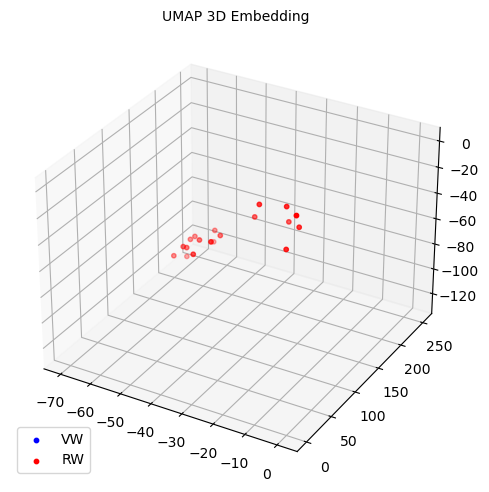

Estimated number of clusters: 0
Estimated number of noise points: 19
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000


In [12]:
labels, df_labels, n_clusters_, n_noise_, _ = uu.see_OG_latent_space(labeledDataByClass, latentData_z, labeledDataByType, imgLabels1, label1, label2, NUM_COMPONENTS)

## UMAP

This is the simplest implementation of UMAP.  It uses the parameters in the .yml file.

In [14]:
min_distance = MIN_DISTANCE[0]
num =2#NUM_NEIGHBORS[0]

umap_embedded_data = uu.draw_umap(latentData_z, num, min_distance, NUM_COMPONENTS)

## DBSCAN Clustering
Attempts to find clusters in the result returned by UMAP.  Prints the following statistics.

|Metric|Range|Explanation|
|---|---|---|
|Homogeneity| 0.0 to 1.0| 1.0 means all of clusters contain only data points which are members of a single class|
|Completeness|0.0 to 1.0| 1.0 means all the data points that are members of a given class are elements of the same cluster|
|V-measure|-|harmonic mean between homogeneity and completeness|
|Adjusted Rand Index|0.0 to 1.0|0.0 for random labeling independently of the number of clusters and samples and exactly 1.0 when the clusterings are identical|
|Adjusted Mutual Information|-|ccounts for the fact that the MI is generally higher for two clusterings with a larger number of clusters, regardless of whether there is actually more information shared|

In [15]:
dbscanlabels, df_labels, n_clusters_, n_noise_, db_stats = \
        uu.clusterDBSCAN(umap_embedded_data, labels_true_class, NUM_COMPONENTS)
cluster_labels = pd.DataFrame.from_dict({'Cluster ID': dbscanlabels})

Estimated number of clusters: 0
Estimated number of noise points: 19
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000


## Distance Calculations
Currently using the [Hausdorff Distance](https://en.wikipedia.org/wiki/Hausdorff_distance).  

In [16]:
cluster_distances = uu.getHausdorffDist(n_clusters_, dbscanlabels, umap_embedded_data)

metrics = {'h_dist': cluster_distances, 'metrics': db_stats}
with open("crosstrain_umap_metrics.json", "w") as outfile:
    json.dump(metrics, outfile)

0it [00:00, ?it/s]


In [17]:
pd.DataFrame.from_dict(metrics)

,h_dist,metrics
n_clusters,NaN,0.0
n_noise,NaN,19.0
homogeneity,NaN,1.0
completeness,NaN,1.0
V-measure,NaN,1.0
adj_rand_ind,NaN,1.0
adj_mut_info,NaN,1.0


## Format UMAP Embedding & DBSCAN Clustering Information into a Pandas DataFrame

In [18]:
umap_embed_df = pd.DataFrame(umap_embedded_data)
umap_embed_df.columns = LD_COLUMNS
umap_data = pd.concat([latentData[["Unnamed: 0", "Class", "DataType", "filename", "img_path", "z_filename", "z_img_path"]], cluster_labels, umap_embed_df], axis=1)

In [19]:
umap_data.head()

,Unnamed: 0,Class,DataType,filename,img_path,z_filename,z_img_path,Cluster ID,z0,z1,...,z22,z23,z24,z25,z26,z27,z28,z29,z30,z31
0,0,Plane,RW,biplane_00.png,data/biplane_00.png,None,data/None,-1,8.803608,1.221762,...,7.073973,4.794032,0.249676,4.767695,-0.587812,2.168298,-0.582330,5.723341,-2.022280,6.059303
1,1,Plane,RW,biplane_01.png,data/biplane_01.png,None,data/None,-1,9.395815,9.143758,...,2.205101,7.518552,5.762157,7.543535,3.830263,6.338415,9.893173,10.201375,5.049489,4.192052
2,2,Plane,RW,biplane_03.png,data/biplane_03.png,None,data/None,-1,5.799417,5.503187,...,4.882493,5.884676,7.547641,-1.041279,5.466304,11.098438,4.736075,0.277186,-1.723230,6.930176
3,3,Plane,RW,biplane_04.png,data/biplane_04.png,None,data/None,-1,5.144597,3.097935,...,9.603074,1.956293,4.746626,1.124341,0.708268,7.685358,9.160091,6.195323,3.418391,2.051172
4,4,Plane,RW,biplane_05.png,data/biplane_05.png,None,data/None,-1,5.772846,5.561194,...,4.822309,5.945179,7.607595,-0.998214,5.489072,11.034298,4.675673,0.217362,-1.782888,6.867155


## Load Original Images (For Interactive Plotting)

In [21]:
latentData['img_path'].tolist()
img_data = uu.load_images(os.path.join(cwd, IMAGE_PATH), latentData['filename'].tolist())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 235.04it/s]


## Define Dash App for Interactive UMAP Plot

In [22]:
data_to_plot = umap_data

In [23]:
# Declare the app variable
app = JupyterDash(__name__)

# Lay out the html containers for the app.  On the left is the graph and title; on the right are the controls

app.layout = html.Div([
    html.Div(children=[    
        html.Label(['UMAP Embedding', 
                    dcc.Graph(id='graph', 
                              style={'width': '90wh', 'height': '90vh'},
                              clear_on_unhover=True,),
                    dcc.Tooltip(id="img_display", direction='bottom'),])
        #dcc.Graph(id='graph', responsive=True)])
    ], style={'width': '69%', 'float':'left'}),
    
    html.Div(children=[
        html.H5('Select Classes'),
        dcc.Checklist((data_to_plot['Class'].unique()).tolist(),(data_to_plot['Class'].unique()).tolist(), id='class_checklist'),
        html.Hr(),
        html.H5('Select Super Classes'),
        dcc.Checklist((data_to_plot['DataType'].unique()).tolist(), (data_to_plot['DataType'].unique()).tolist(), id='superclass_checklist'),
        html.Hr(),
        html.H5('Select Components'),
        dcc.Checklist(LD_COLUMNS, [LD_COLUMNS[0], LD_COLUMNS[1], LD_COLUMNS[2]], id='components'),
        html.Hr(),
        html.H5("Color Map"),
        dcc.Dropdown(id='colormap_info', clearable=False, value='Class', options=[{'label': c, 'value': c}for c in list(data_to_plot.columns)]),
        html.Hr(),
        html.H5('Marker Size'), 
        dcc.Slider(min=0, max=30, marks={str(i): str(i) for i in range(0, 30, 5)}, value=1, id='marker_size'),
        html.Hr(),
        html.H5('Marker Transparency'), 
        dcc.Slider(min=0, max=100, marks={str(i): str(i) for i in range(0, 100, 10)}, value=100, id='marker_transparency'),
    ], style={'width':'29%', 'float':'right'})
])

# Define callback to update graph

# the @app.callback(...) is the wrapper for the function that updates the figure
@app.callback(
    [Output('graph', 'figure'),],
    [Input("colormap_info", "value"),
    Input("class_checklist", "value"),
    Input('components', 'value'),
    Input('marker_size', 'value'),
    Input('marker_transparency', 'value'),
    Input('superclass_checklist', 'value'),]
)
def update_figure(color_info, classes, compon, ms, mt, superclasses):
    """
    :param color_info: which data feature to use to color the data points
    :param classes: which classes to plot; filters data
    :param compon: "components", which vector components to plot
    :param ms: marker size
    :param mt: marker transparency
    :param superclasses: which super classes to plot; filters data
    """
    
    # declare empty figure so that the function always has something to return
    fig = go.Figure()
    
    # filter the data based on the controls for classes
    filtered_data = data_to_plot.loc[data_to_plot['Class'].isin(classes)]
    
    if len(superclasses)>0:
        filtered_data = filtered_data.loc[filtered_data['DataType'].isin(superclasses)]
    
    # select the data based on which vector components are specified
    if len(compon)==2:
        x_data = compon[0]
        y_data = compon[1]
        # specify 2D scatter plot when two vectors are chosen
        fig = px.scatter(filtered_data, x=x_data, y=y_data, color=filtered_data[color_info])
        
    if len(compon)>2:
        x_data = compon[0]
        y_data = compon[1]
        z_data = compon[2]
        # specify 3D scatter plot when more than 2 vectors are chosen
        fig = px.scatter_3d(filtered_data, x=x_data, y=y_data, z=z_data, color=filtered_data[color_info])
    
    # if only one vector is selected, it will return an empty graph
    
    # update the plot marker size, transparency, and make sure the default hover is disabled
    fig.update_traces(
        marker=dict(size=ms, opacity=mt/100.),
        selector=dict(mode='markers'),
        hoverinfo="none",
        hovertemplate=None,)
    
    return [go.Figure(data=fig)]

# This function updates the hover pop up image
@app.callback(
    [Output("img_display", "show"),
    Output("img_display", "bbox"),
    Output("img_display", "children"),],
    Input("graph", "hoverData"),
    Input("class_checklist", "value"),
    Input('superclass_checklist', 'value'),
    Input('components', 'value'),
)
def display_hover(hoverData, classes, superclasses, comp):
    """
    :param hoverData: when the cursor hovers over a graph data marker, it returns a hover object
    :param classes: which classes are plotted; filters data
    :param superclasses: which super classes are plotted; filters data
    :param comp: "components", which vector components are plotted 
    """
    
    # if the cursor is not on a data point, do nothing
    if hoverData is None:
        return False, no_update, no_update
    
    # extract the information from the cursor
    hover_data = hoverData["points"][0]
    bbox = hover_data["bbox"]
    num = hover_data["pointNumber"]
    
    # now need to map the hover data to the original data list to extract the image ID
    filtered_data = data_to_plot.loc[data_to_plot['Class'].isin(classes)]
    if len(superclasses)>0:
        filtered_data = filtered_data.loc[filtered_data['DataType'].isin(superclasses)]
    
    # Selects original image info by matching the points in each vector component to the filtered down data list
    # NOTE: the example uses the "data point #" from the pointer to do this mapping,
    # but I found that the "data point #" is actually reused (multiple points with the same ID, I think based on class label), 
    # preventing a unique mapping.  Doing it this way was what worked in the end.
    if len(comp)>1:
        x_data = comp[0]
        y_data = comp[1]
        
        test = filtered_data.loc[(filtered_data[x_data] == hover_data['x']) & (filtered_data[y_data] == hover_data['y'])]
        
    if len(comp)>2:
        z_data = comp[2]
        test = filtered_data.loc[(filtered_data[x_data] == hover_data['x']) & (filtered_data[y_data] == hover_data['y']) & (filtered_data[z_data] == hover_data['z'])]
    
    img_id = int(test['Unnamed: 0'])
    im_matrix = img_data[img_id]
    
    im_url = uu.np_image_to_base64(im_matrix)
    children = [
        html.Div([
            html.Img(
                src=im_url,
                style={"width": "50px", 'display': 'block', 'margin': '0 auto'},
            ),
            # this next line shows text with the image hover; saving so that the reconstruction score can be added later
            # html.P("MNIST Digit " + str(labels[num]), style={'font-weight': 'bold'})
        ])
    ]

    return True, bbox, children
    

Every time you run the next cell, it ties up a new port.  Right now, the only way that I have found for this version of dash/plotly to release the ports is to restart the notebook kernel.

In [24]:
port_num += 1 # small work around so that it updates the port number every time the cell is rerun (server doesn't auto release port)
app.run_server(mode='inline', port=port_num)